# 1 Packages

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from clearml import Task

from keras.layers import RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Imbalanced data')

ClearML Task: overwriting (reusing) task id=6a36263d972d4370aa6a22b7c29bd170
2024-04-14 13:55:57,130 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/6a36263d972d4370aa6a22b7c29bd170/output/log


# 1.1 Create the Dataset and Split it into Training and Validation Sets


In [ ]:
from pathlib import Path
import imghdr
from PIL import Image

data_dir = "D:/University/FinalDatasetSplited/train/21_st_Century, Blobitecture"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [68]:
def is_image_corrupted(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        return False  
    except tf.errors.InvalidArgumentError:
        return True  

root_directory = 'D:/University/FinalDatasetSplited/test'
corrupted_images = []
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            if is_image_corrupted(image_path):
                try:
                    print(image_path)
                    img = Image.open(image_path)

                    print("fail here")
                    img_format = 'JPEG'
                    img.save(image_path, format=img_format)

                    print(f"Header fixed for {image_path}")
                except Exception as e:
                    print(f"Failed to fix header for {image_path}: {e}")

for image_path in corrupted_images:
    print("Corrupted image:", image_path)

D:/University/FinalDatasetSplited/test\21_st_Century, Neo-futurism architecture\03116.jpg
Failed to fix header for D:/University/FinalDatasetSplited/test\21_st_Century, Neo-futurism architecture\03116.jpg: name 'Image' is not defined
D:/University/FinalDatasetSplited/test\Classical, Roman Classical architecture\2382.jpg
Failed to fix header for D:/University/FinalDatasetSplited/test\Classical, Roman Classical architecture\2382.jpg: name 'Image' is not defined
D:/University/FinalDatasetSplited/test\Early_Christian_Medieval, Medieval Architecture\3288.jpg
Failed to fix header for D:/University/FinalDatasetSplited/test\Early_Christian_Medieval, Medieval Architecture\3288.jpg: name 'Image' is not defined


In [28]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = 'D:/University/FinalDatasetSplited/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=0.2,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            seed=42)
validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 label_mode='categorical',
                                                                 seed=42)

Found 16292 files belonging to 51 classes.
Using 13034 files for training.
Found 16292 files belonging to 51 classes.
Using 3258 files for validation.


Represent data

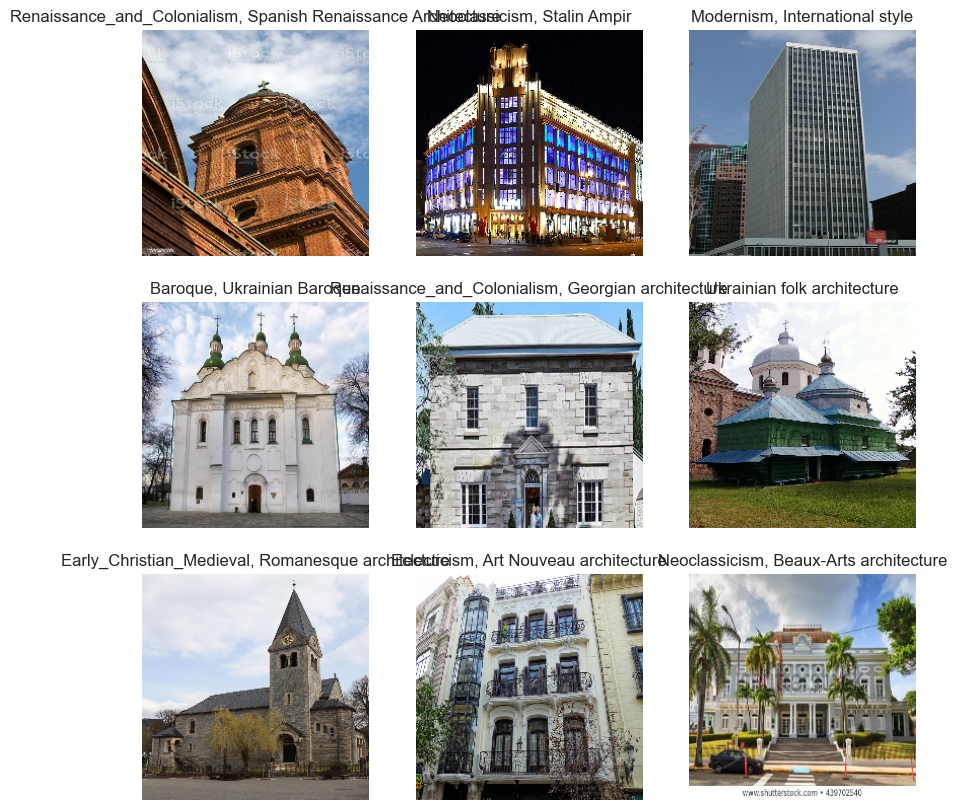

In [4]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy().astype("int")
        plt.title(class_names[np.where(label == 1)[0][0]])
        plt.axis("off")

# 2 Preprocess and Augment Training Data

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [30]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]))
    data_augmentation.add(RandomContrast(factor=0.2))
    return data_augmentation

Augumented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: num must be an integer with 1 <= num <= 9, not 10

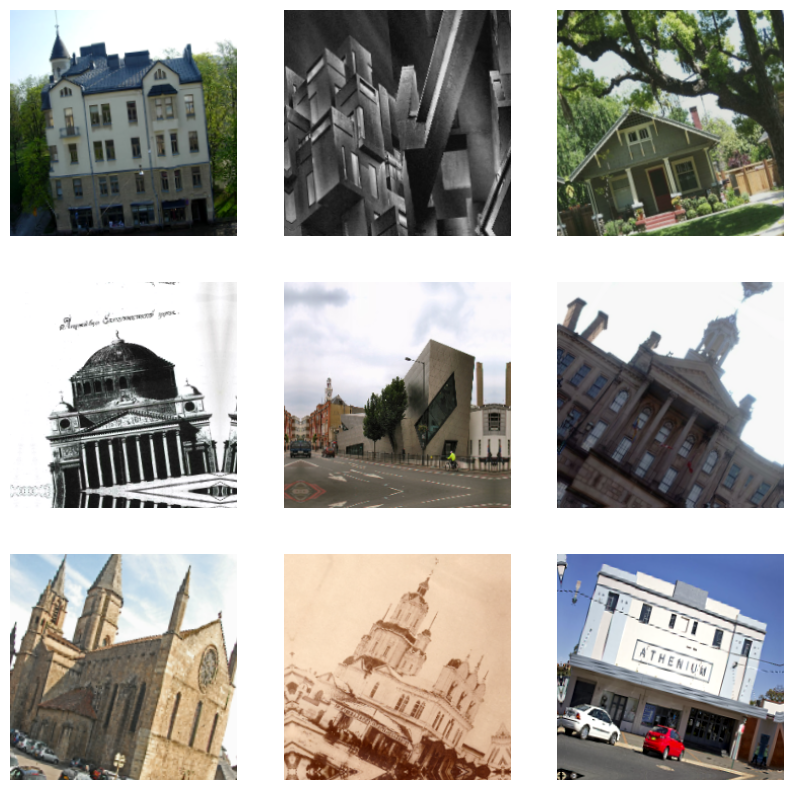

In [11]:
data_augmentation = data_augmenter()

subset_dataset = train_dataset.take(1)  # Take first 10 samples for testing

plt.figure(figsize=(10, 10))
for images, _ in subset_dataset:
    for i in range(len(images)):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0), training=True)
        plt.imshow(augmented_image[0])  # Normalize for display
        plt.axis('off')

In [31]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE,
                                                    include_top=True,
                                                    weights='imagenet')

In [33]:

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

In [15]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.003921569


# 3 Using EfficientNetB0V2

In [43]:
def arc_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                        include_top=False,
                                                        weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalMaxPooling2D()(x)

    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.BatchNormalization(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(51, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [45]:
model2 = arc_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy', tf.keras.metrics.F1Score],
               )
initial_epochs = 50
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.1611 - f1_score: 0.0616 - loss: 3.4577 - val_accuracy: 0.2624 - val_f1_score: 0.0439 - val_loss: 2.6821 - learning_rate: 0.0010
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.2730 - f1_score: 0.1459 - loss: 2.5439 - val_accuracy: 0.3597 - val_f1_score: 0.0587 - val_loss: 2.3600 - learning_rate: 0.0010
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.3035 - f1_score: 0.1769 - loss: 2.4061 - val_accuracy: 0.2707 - val_f1_score: 0.0526 - val_loss: 2.6039 - learning_rate: 0.0010
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.3306 - f1_score: 0.2065 - loss: 2.2948
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
408/408 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.3306 - f1_score: 0.2065 - loss: 2.2947 - val_accuracy: 0.3524 - val_f1_score: 0.0630 - val_loss: 2.2797 - learning_rate: 0.0010
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/

Results

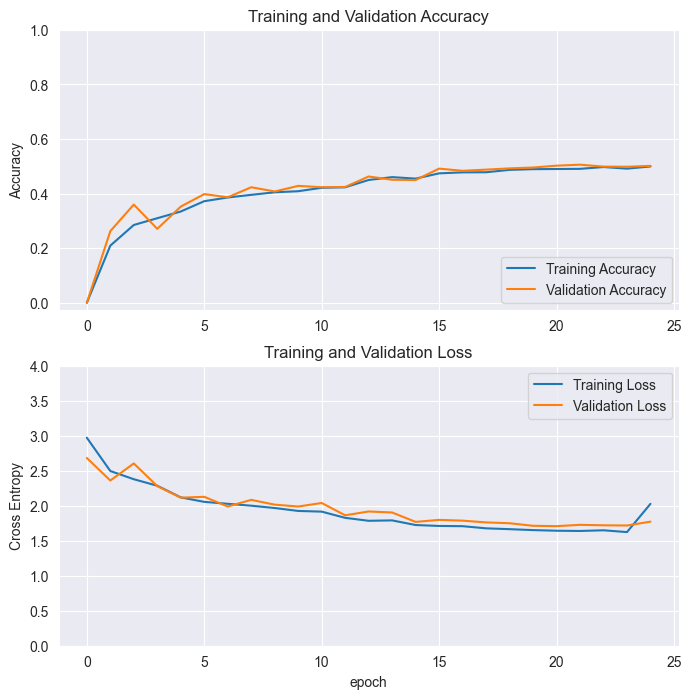

In [61]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss'][:25]
val_loss = history.history['val_loss'][:25]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
from tensorflow.keras import layers

base_model = model2
base_model.trainable = True

fine_tune_at = -10

# for layer in base_model.layers[:fine_tune_at]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False
for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
loss_function = tf.keras.losses.CategoricalCrossentropy()
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy', tf.keras.metrics.F1Score]

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset,
                          callbacks=[learning_rate_reduction, early_stopping]
                          )

Epoch 24/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1169s 3s/step - accuracy: 0.3529 - f1_score: 0.2667 - loss: 2.3204 - val_accuracy: 0.4960 - val_f1_score: 0.1075 - val_loss: 1.7724 - learning_rate: 1.0000e-04
Epoch 25/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1112s 3s/step - accuracy: 0.5017 - f1_score: 0.4134 - loss: 1.6316 - val_accuracy: 0.5178 - val_f1_score: 0.1102 - val_loss: 1.6790 - learning_rate: 1.0000e-04
Epoch 26/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1116s 3s/step - accuracy: 0.5300 - f1_score: 0.4448 - loss: 1.4846 - val_accuracy: 0.5421 - val_f1_score: 0.1167 - val_loss: 1.5833 - learning_rate: 1.0000e-04
Epoch 27/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1113s 3s/step - accuracy: 0.5703 - f1_score: 0.4881 - loss: 1.3578 - val_accuracy: 0.5626 - val_f1_score: 0.1270 - val_loss: 1.4654 - learning_rate: 1.0000e-04
Epoch 28/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1115s 3s/step - accuracy: 0.5837 - f1_score: 0.5066 - loss: 1.2986 - val_accuracy: 0.5887 - val_f1_score: 0.1304 - val_loss: 1.3943 - learning_rate: 1

Results

In [58]:
acc

[0.0,
 0.20937548577785492,
 0.2850237786769867,
 0.30980512499809265,
 0.33435630798339844,
 0.3721037209033966,
 0.3856835961341858,
 0.3953506350517273,
 0.4047107696533203,
 0.408623605966568,
 0.4212060868740082,
 0.4229706823825836,
 0.4498235285282135,
 0.46025779843330383,
 0.4548105001449585,
 0.4740678369998932,
 0.4776737689971924,
 0.4780573844909668,
 0.48680374026298523,
 0.4894123077392578,
 0.48994937539100647,
 0.49056315422058105,
 0.49716126918792725,
 0.4913303554058075,
 0.49923276901245117,
 0.4112321734428406,
 0.5086696147918701,
 0.5400490760803223,
 0.5705845952033997,
 0.5904557108879089,
 0.611170768737793,
 0.6321160197257996,
 0.6514500379562378,
 0.6690194606781006,
 0.6810649037361145,
 0.7027006149291992,
 0.7160503268241882,
 0.7271750569343567,
 0.7465858459472656,
 0.7577105760574341,
 0.7686818838119507,
 0.7793463468551636,
 0.7914684414863586,
 0.7974528074264526,
 0.8089611530303955,
 0.8189350962638855,
 0.8291391730308533,
 0.846785306930542,
 

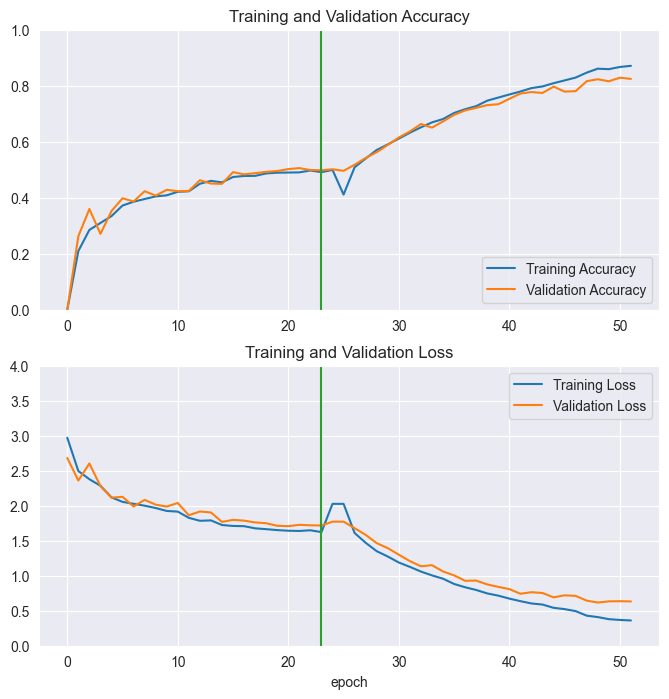

In [62]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([23, 23],
         plt.ylim())
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([23, 23],
         plt.ylim())
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
base_model = model2
base_model.trainable = True

fine_tune_at = -10

# for layer in base_model.layers[:fine_tune_at]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False
for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
loss_function = tf.keras.losses.CategoricalCrossentropy()
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

base_model.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

fine_tune_epochs1 = 50
total_epochs = initial_epochs + fine_tune_epochs + fine_tune_epochs1

history_fine = base_model.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history_fine.epoch[-1],
                          validation_data=validation_dataset,
                          callbacks=[learning_rate_reduction, early_stopping]
                          )

Epoch 50/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1215s 3s/step - accuracy: 0.8369 - loss: 0.4532 - val_accuracy: 0.8122 - val_loss: 0.6455 - learning_rate: 1.0000e-04
Epoch 51/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1128s 3s/step - accuracy: 0.8504 - loss: 0.4269 - val_accuracy: 0.8303 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 52/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.8574 - loss: 0.4116 - val_accuracy: 0.8174 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 53/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8552 - loss: 0.4178
Epoch 53: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
408/408 ━━━━━━━━━━━━━━━━━━━━ 1127s 3s/step - accuracy: 0.8552 - loss: 0.4178 - val_accuracy: 0.8106 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 54/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 1126s 3s/step - accuracy: 0.8788 - loss: 0.3484 - val_accuracy: 0.8171 - val_loss: 0.6475 - learning_rate: 5.0000e-05


# Evaluate the results

In [69]:
test_directory = 'D:/University/FinalDatasetSplited/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                            shuffle=False,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            seed=42)

Found 1808 files belonging to 51 classes.


In [73]:
loss, accuracy = model2.evaluate(train_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Train Loss:', loss, 'Train Accuracy:', accuracy)

Train Loss: 0.23186098039150238 Train Accuracy: 0.9172932505607605


In [72]:
loss, accuracy = model2.evaluate(validation_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Validation Loss:', loss, 'Validation Accuracy:', accuracy)

Validation Loss: 0.6052199006080627 Validation Accuracy: 0.8302639722824097


In [71]:
loss, accuracy = model2.evaluate(test_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

Test Loss: 1.6582838296890259 Test Accuracy: 0.6294247508049011


In [75]:
from sklearn.metrics import classification_report

prediction = model2.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 554ms/step
              precision    recall  f1-score   support

           0       0.64      0.61      0.62        23
           1       0.66      0.79      0.72        34
           2       0.89      0.64      0.74        25
           3       0.50      0.18      0.27        11
           4       0.57      0.66      0.61        32
           5       0.56      0.42      0.48        12
           6       0.53      0.70      0.60        46
           7       0.50      0.38      0.43        13
           8       0.33      0.08      0.13        12
           9       0.33      0.24      0.28        17
          10       0.73      0.62      0.67        13
          11       0.68      0.67      0.67        42
          12       0.77      0.87      0.82        39
          13       0.97      0.85      0.91        41
          14       0.55      0.79      0.65        14
          15       0.75      0.75      0.75        12
          16       0.60      0.84      

In [76]:
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels, axis=1))

predicted_labels = np.argmax(prediction, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))

                                                                precision    recall  f1-score   support

                                   21_st_Century, Blobitecture       0.64      0.61      0.62        23
                               21_st_Century, Deconstructivism       0.66      0.79      0.72        34
                               21_st_Century, Eco-architecture       0.89      0.64      0.74        25
                      21_st_Century, Neo-futurism architecture       0.50      0.18      0.27        11
                        21_st_Century, Postmodern architecture       0.57      0.66      0.61        32
                          Baroque, Andean Baroque Architecture       0.56      0.42      0.48        12
                                 Baroque, Baroque architecture       0.53      0.70      0.60        46
                      Baroque, Earthquake Baroque Architecture       0.50      0.38      0.43        13
                                  Baroque, Rococo Architecture 

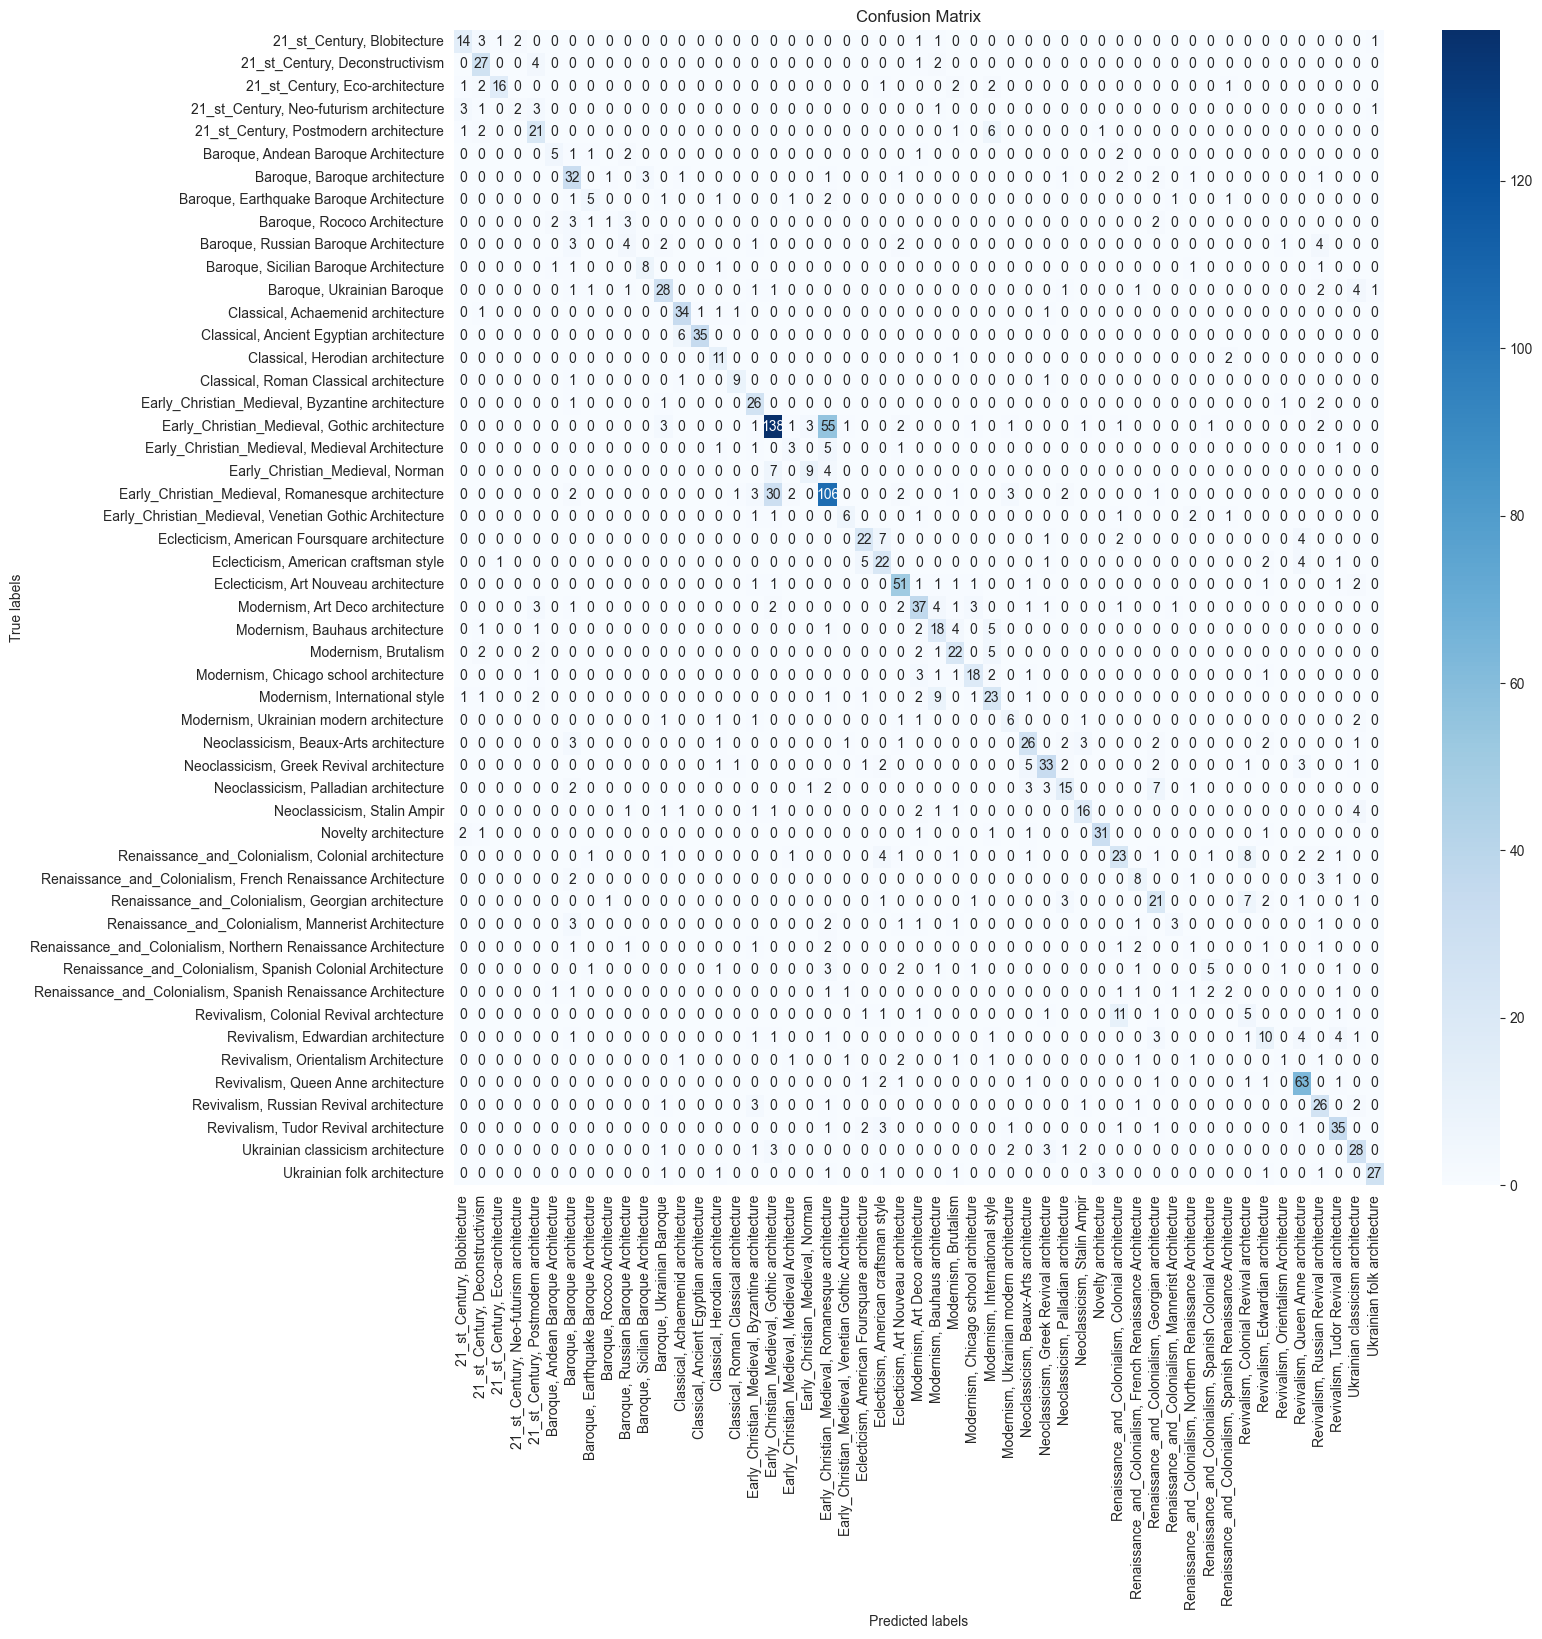

In [81]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [57]:
model_name = "model_imbalanced1_v1"
model_json = model2.to_json()
with open(f"{model_name}_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5 file
model2.save_weights(f"{model_name}_weights.h5")

TypeError: F1Score.get_config() missing 1 required positional argument: 'self'

In [56]:

tf.keras.models.save_model(model2, f"{model_name}.h5")

TypeError: cannot pickle 'module' object

In [82]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('models/model_imbalanced1_v1.tflite', 'wb') as f:
    f.write(tflite_model)

AttributeError: 'Functional' object has no attribute '_get_save_spec'

In [84]:

for epoch, history in enumerate(acc):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(val_loss):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(val_acc):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)

In [88]:
task.upload_artifact(artifact_object="model_imbalanced1_v1.h5", name="imbalanced")

True